In [106]:
# pip install requests pandas ccxt alpha-vantage==3.0.0 matplotlib seaborn
import ccxt
import pandas as pd
import numpy as np
from alpha_vantage.foreignexchange import ForeignExchange
from alpha_vantage.timeseries import TimeSeries
from datetime import datetime
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [107]:
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
pd.options.display.float_format = '{:.2f}'.format

In [108]:
import os
print(os.getcwd())

BASE_DIR = os.getcwd()

c:\workspace\hit_ml_dl\practice


## CCXT API 데이터 수집 함수 정의

In [1]:
def get_ccxt_data(exchange, base, quote, start_date, end_date, output_dir=BASE_DIR):
    """
    CCXT를 사용하여 암호화폐 또는 Forex 데이터를 수집하는 함수

    Parameters:
    - exchange: 거래소 이름 (예: 'kraken', 'oanda')
    - base: 기준 통화 (예: 'BTC', 'USD')
    - quote: 상대 통화 (예: 'USD', 'EUR')
    - start_date: 데이터 시작 날짜 (예: '2023-01-01')
    - end_date: 데이터 종료 날짜 (예: '2025-07-31')

    Returns:
    - pandas DataFrame with 'timestamp', 'close', 'volume' columns
    """ 
    try:
        exchange_class = getattr(ccxt, exchange.lower())
        exchange = exchange_class()
        exchange.load_markets()

        symbol = f"{base}/{quote}"
        if symbol not in exchange.symbols:
            raise ValueError(f"{symbol}은(는) {exchange}에서 지원되지 않습니다.")
        
        timeframe = '1d'
        since = int(pd.to_datetime(start_date).timestamp() * 1000)

        all_data = []
        while True:
            candles = exchange.fetch_ohlcv(symbol, timeframe, since=since, limit=215)
            if not candles:
                break
            df = pd.DataFrame(
                candles, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume']
            )
            df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
            df = df[['timestamp', 'close', 'volume']]
            all_data.append(df)

            last_timestamp = candles[-1][0]
            since = last_timestamp + 24 * 60 * 60 * 1000

            if pd.to_datetime(last_timestamp, unit='ms') > pd.to_datetime(end_date):
                break
        
        df = pd.concat(all_data)
        df.set_index('timestamp', inplace=True)
        df = df.rename(columns={
            'close': f'{base}_{quote}',
            'volume': f'{base}_Volume'
        })
        df = df.loc[start_date:end_date]

        csv_file = os.path.join(output_dir, f"{exchange}_{base}_{quote}.csv")
        df.to_csv(csv_file, encoding='utf-8')
        print(f"{exchange} {base}/{quote} 데이터 크기: {df.shape}, 저장: {csv_file}")

    
    except Exception as e:
        print(f"get_ccxt_data({exchange}, {base}/{quote}) 오류: {e}")
        return None

NameError: name 'BASE_DIR' is not defined

## Alpha Vantage API 데이터 수집 함수 정의

In [110]:
def get_alpha_vantage_forex_data(base, quote, start_date, end_date, api_key, output_dir=BASE_DIR):
    """
    Alpha Vantage를 사용하여 Forex 데이터를 수집하는 함수
    
    Paramters:
    - base: 기준 통화 (예: 'USD')
    - quote: 상대 통화 (예: 'EUR')
    - start_date: 데이터 시작 날짜
    - end_date: 데이터 종료 날짜
    - api_key: Alpha Vantage API 키

    Returns:
    - pandas DataFrame with 'base_quote' column
    """
    try:
        forex = ForeignExchange(key=api_key, output_format='pandas')
        data, _ = forex.get_currency_exchange_daily(from_symbol=base, to_symbol=quote, outputsize='full')
        data = data[['4. close']].rename(columns={'4. close': f'{base}_{quote}'})
        data.index = pd.to_datetime(data.index)
        data = data.sort_index()  # 인덱스 정렬
        # 오늘 날짜로 제한
        end_date = min(pd.to_datetime(end_date), pd.to_datetime(datetime.now().date()))
        data =  data.loc[start_date:end_date]
    
        csv_file = os.path.join(output_dir, f"alpha_vantage_{base}_{quote}.csv")
        data.to_csv(csv_file, encoding='utf-8')
        print(f"Alpha Vantage {base}/{quote} 데이터 크기: {data.shape}, 저장: {csv_file}")
        
        return data

    except Exception as e:
        print(f"get_alpha_vantage_forex_data({base}/{quote}) 오류: {e}")
        return None


def get_alpha_vantage_gold_data(start_date, end_date, api_key, output_dir=BASE_DIR):
    """
    Alpha Vantage를 사용하여 금(XAU/USD) 데이터를 수집하는 함수

    Parameters:
    - start_date: 데이터 시작 날짜
    - end_date: 데이터 종료 날짜
    - api_key: Alpha Vantage API 키

    Returns:
    - pandas DataFrame with 'XAU_USD' column
    """
    try:
        ts = TimeSeries(key=api_key, output_format='pandas')
        data, _ = ts.get_daily(symbol='XAUUSD', outputsize='full')
        data = data[['4. close']].rename(columns={'4. close': 'XAU_USD'})
        data.index = pd.to_datetime(data.index)
        data = data.sort_index()  # 인덱스 정렬
        # 오늘 날짜로 제한
        end_date = min(pd.to_datetime(end_date), pd.to_datetime(datetime.now().date()))
        data = data.loc[start_date:end_date]

        csv_file = os.path.join(output_dir, "alpha_vantage_XAU_USD.csv")
        data.to_csv(csv_file, encoding='utf-8')
        print(f"Alpha Vantage XAU/USD 데이터 크기: {data.shape}, 저장: {csv_file}")

        return data
    
    except Exception as e:
        print(f"get_alpha_vantage_gold_data 오류: {e}")
        return None

## 데이터 수집 및 통합 함수

In [111]:
def collect_crypto_forex_data(
    start_date, 
    end_date, 
    alpha_vantage_api_key,
    output_file='crypto_forex_data.csv'
):
    """
    BTC/Fiat 및 Forex 데이터를 수집하고 통합하여 CSV로 저장하는 함수
    
    Parameters:
    - start_date: 데이터 시작 날짜 (예: '2023-01-01')
    - end_date: 데이터 종료 날짜 (예: '2025-07-31')
    - alpha_vantage_api_key: Alpha Vantage API 키
    - output_file: 저장할 CSV 파일 이름
    
    Returns:
    - merged_data: 통합된 pandas DataFrame 
    """
    try:
        # 오늘 날짜로 end_date 제한
        end_date = min(pd.to_datetime(end_date), pd.to_datetime(datetime.now().date())).strftime('%Y-%m-%d')
        print(f"수집 기간: {start_date} ~ {end_date}")

        # BTC/Fiat 지표 수집
        btc_usd = get_ccxt_data('kraken', 'BTC', 'USD', start_date, end_date)
        btc_eur = get_ccxt_data('binance', 'BTC', 'EUR', start_date, end_date)
        btc_jpy = get_ccxt_data('binance', 'BTC', 'JPY', start_date, end_date)  # Bitflyer 대신 Binance
        btc_krw = get_ccxt_data('bithumb', 'BTC', 'KRW', start_date, end_date)

        # Forex 데이터 수집 (Alpha Vantage로 전환, Oanda는 불확실)
        usd_eur = get_alpha_vantage_forex_data('USD', 'EUR', start_date, end_date, alpha_vantage_api_key)
        usd_jpy = get_alpha_vantage_forex_data('USD', 'JPY', start_date, end_date, alpha_vantage_api_key)
        usd_cny = get_alpha_vantage_forex_data('USD', 'CNY', start_date, end_date, alpha_vantage_api_key)
        usd_krw = get_alpha_vantage_forex_data('USD', 'KRW', start_date, end_date, alpha_vantage_api_key)
        usd_gold = get_alpha_vantage_gold_data(start_date, end_date, alpha_vantage_api_key)

        # 데이터 통합
        data_frames = [btc_usd, btc_eur, btc_jpy, btc_krw, usd_eur, usd_jpy, usd_cny, usd_krw, usd_gold]
        data_frames = [df for df in data_frames if df is not None]
        if not data_frames:
            raise ValueError("수집된 데이터가 없습니다.")
        
        merged_data = pd.concat(data_frames, axis=1, join='inner')
        print("통합된 데이터 크기:", merged_data.shape)

        # 결측치 확인
        print("결측치 요약:\n", merged_data.isnull().sum())

        # 데이터 저장
        merged_data.to_csv(output_file, encoding='utf-8')
        print(f"데이터가 '{output_file}'로 저장되었습니다.")

        return merged_data

    except Exception as e:
        print(f"collect_crypto_forex_data 오류: {e}")
        return None

In [112]:
# 실행 (__name__ == "__main__")
ALPHA_VANTAGE_API_KEY = "LB15G5QAECM4H5M7"
start_date = '2023-01-01'
end_date = '2025-07-31'
output_file = 'crypto_forex_data.csv'

merged_data = collect_crypto_forex_data(start_date, end_date, ALPHA_VANTAGE_API_KEY, output_file)

수집 기간: 2023-01-01 ~ 2025-07-31
Kraken BTC/USD 데이터 크기: (720, 2), 저장: c:\workspace\hit_ml_dl\practice\Kraken_BTC_USD.csv
Binance BTC/EUR 데이터 크기: (943, 2), 저장: c:\workspace\hit_ml_dl\practice\Binance_BTC_EUR.csv
Binance BTC/JPY 데이터 크기: (507, 2), 저장: c:\workspace\hit_ml_dl\practice\Binance_BTC_JPY.csv
Bithumb BTC/KRW 데이터 크기: (942, 2), 저장: c:\workspace\hit_ml_dl\practice\Bithumb_BTC_KRW.csv
Alpha Vantage USD/EUR 데이터 크기: (673, 1), 저장: c:\workspace\hit_ml_dl\practice\alpha_vantage_USD_EUR.csv
Alpha Vantage USD/JPY 데이터 크기: (673, 1), 저장: c:\workspace\hit_ml_dl\practice\alpha_vantage_USD_JPY.csv
Alpha Vantage USD/CNY 데이터 크기: (671, 1), 저장: c:\workspace\hit_ml_dl\practice\alpha_vantage_USD_CNY.csv
Alpha Vantage USD/KRW 데이터 크기: (673, 1), 저장: c:\workspace\hit_ml_dl\practice\alpha_vantage_USD_KRW.csv
Alpha Vantage XAU/USD 데이터 크기: (804, 1), 저장: c:\workspace\hit_ml_dl\practice\alpha_vantage_XAU_USD.csv
통합된 데이터 크기: (667, 5)
결측치 요약:
 USD_EUR    0
USD_JPY    0
USD_CNY    0
USD_KRW    0
XAU_USD    0
dtype:

In [113]:
# data 폴더의 모든 CSV 파일 읽기
csv_files = [f for f in os.listdir('data') if f.endswith('.csv')]
dfs = [pd.read_csv(f'data/{file}', index_col=0, parse_dates=True) for file in csv_files]

# 모든 데이터프레임을 날짜 기준으로 병합
merged_df = pd.concat(dfs, axis=1, join='inner')
merged_df.to_csv(BASE_DIR + "/data/" + 'merged_data.csv', encoding='utf-8')

print(f"병합 완료: {merged_df.shape}, 저장: merged_data.csv")

병합 완료: (360, 52), 저장: merged_data.csv


## 기술 지표 생성

In [114]:
# 지표 계산 함수들
def calculate_rsi(prices, window=14):
    """RSI 계산"""
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_bollinger_bands(prices, window=20, num_std=2):
    """볼린저 밴드 계산"""
    rolling_mean = prices.rolling(window=window).mean()
    rolling_std = prices.rolling(window=window).std()
    
    upper_band = rolling_mean + (rolling_std * num_std)
    lower_band = rolling_mean - (rolling_std * num_std)
    bb_percent = (prices - lower_band) / (upper_band - lower_band)
    
    return rolling_mean, upper_band, lower_band, bb_percent

def calculate_moving_averages(prices):
    """이동평균 계산"""
    ma_20 = prices.rolling(window=20).mean()
    ma_50 = prices.rolling(window=50).mean()
    return ma_20, ma_50

def calculate_volume_indicators(df):
    """거래량 지표 계산"""
    # 거래량 이동평균 비율
    vol_ma_20 = df['volume'].rolling(window=20).mean()
    vol_ratio = df['volume'] / vol_ma_20
    
    # 가격-거래량 상관관계 (20일 롤링)
    price_vol_corr = df['close'].rolling(window=20).corr(df['volume'])
    
    return vol_ratio, price_vol_corr

In [119]:
# 1순위 구현사항
# 로그 수익률: np.log(close / close.shift(1))
# RSI (14일): 과매수/과매도 신호
# 볼린저 밴드: %B 지표로 변환
# 이동평균 비율: MA20/MA50 비율

# 2순위 구현사항
# StandardScaler
# 거래량 지표: 거래량 비율, 가격-거래량 상관관계

import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

print(os.getcwd())
BEFORE_FEATURE_PATH = BASE_DIR + "/data/" + "merged_data.csv"
AFTER_FEATURE_PATH = BASE_DIR + "/data/" + "merged_data_features.csv"

# 1. 데이터 로드 및 전처리
def load_and_clean_data():
    df = pd.read_csv(BEFORE_FEATURE_PATH, encoding='utf-8')
    df['date'] = pd.to_datetime(df.iloc[:, 0])
    df['btc_usd'] = df['BTC_EUR'] / df['USD_EUR']

    base_data = df[['date', 'btc_usd', 'BTC_Volume']].copy()
    base_data.columns = ['date', 'price', 'volume']
    base_data = base_data.dropna().reset_index(drop=True)
    
    print(f"데이터 기간: {base_data['date'].min()} ~ {base_data['date'].max()}")
    print(f"총 {len(base_data)}일 데이터")
   
    return df, base_data

# 2. 핵심 기술지표 생성 (1순위만)
def create_core_features(df):
    data = df.copy()

    # log return
    if 'log_returns' not in data.columns:
        data['log_returns'] = np.log(data['price'] / data['price'].shift(1))

    # RSI (14)
    if 'rsi' not in data.columns:
        delta = data['price'].diff()
        gain = delta.where(delta > 0, 0).rolling(14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
        rs = gain / loss
        data['rsi'] = 100 - (100 / (1 + rs))

    # 볼린저 밴드 %B
    if 'bb_percent' not in data.columns:
        ma20 = data['price'].rolling(20).mean()
        std20 = data['price'].rolling(20).std()
        data['bb_percent'] = (data['price'] - (ma20 - 2 * std20)) / (4 * std20)

    # 이동평균 비율
    if 'ma_ratio' not in data.columns:
        ma20 = data['price'].rolling(20).mean()
        ma50 = data['price'].rolling(50).mean()
        data['ma_ratio'] = ma20 / ma50

    # 거래량 비율
    if 'vol_ratio' not in data.columns:
        vol_ma = data['volume'].rolling(20).mean()
        data['vol_ratio'] = data['volume'] / vol_ma

    # 결측치 제거
    print(data.isnull().sum().to_string())
    data = data.dropna().reset_index(drop=True)

    # 저장
    data.to_csv(AFTER_FEATURE_PATH, index=False, encoding='utf-8')
    return data

# 3. 원본 CSV에 기술지표 컬럼 추가
def update_original_csv(original_df, features_df):
    feature_columns = ['log_returns', 'rsi', 'bb_percent', 'ma_ratio', 'vol_ratio', 'price_vol_corr']
    original_df['date'] = pd.to_datetime(original_df.iloc[:, 0])
    
    for col in feature_columns:
        if col in features_df.columns:
            merge_data = features_df[['date', col]].copy()
            original_df = original_df.merge(merge_data, on='date', how='left')
    
    original_df.to_csv(AFTER_FEATURE_PATH, index=False)
    print(f"merged_data_updated.csv 저장 완료: {original_df.shape}")
    print(f"추가된 컬럼: {feature_columns}")
    
    return original_df

c:\workspace\hit_ml_dl\practice


In [120]:
# 결측값 제거
def handle_missing_values(df):
    data = df.copy()
    original_length = len(data)

    # 1. 로그 수익률 (1개 결측) - 제거 (계산 불가능)
    if 'log_returns' in data.columns:
        data = data.dropna(subset=['log_returns'])
        
    # 2. RSI (13개 결측) - 부분 채우기 + 제거
    if 'rsi' in data.columns:
        # RSI가 계산되기 시작하는 시점부터 유효한 데이터로 간주
        # 처음 10개는 제거하고, 나머지는 전진 채우기
        rsi_start_idx = data['rsi'].first_valid_index()
        if rsi_start_idx is not None and rsi_start_idx > 10:
            data = data.iloc[10:].reset_index(drop=True)
            data['rsi'] = data['rsi'].fillna(method='ffill')

    # 3. 볼린저 밴드 (19개 결측) - 이동평균으로 추정
    if 'bb_percent' in data.columns:
        bb_missing_mask = data['bb_percent'].isnull()
        data.loc[bb_missing_mask, 'bb_percent'] = 0.5

    # 4. 이동평균 비율 (49개 결측) - 점진적 처리
    if 'ma_ratio' in data.columns:
        ma_missing_mask = data['ma_ratio'].isnull()
        data.loc[ma_missing_mask, 'ma_ratio'] = 1.0
    
    # 5. 거래량 비율 (19개) - 1.0으로 초기화 (중립)
    if 'vol_ratio' in data.columns:
        vol_missing_mask = data['vol_ratio'].isnull()
        data.loc[vol_missing_mask, 'vol_ratio'] = 1.0
    
    # 6. 가격-거래량 상관관계 - 0으로 초기화 (증립)
    if 'price_vol_corr' in data.columns:
        corr_missing_mask = data['price_vol_corr'].isnull()
        data.loc[corr_missing_mask, 'price_vol_corr'] = 0.0

    # 최종 결측값 확인
    final_missing = data.isnull().sum()
    remaining_nulls = final_missing[final_missing > 0]

    if len(remaining_nulls) == 0:
        print("모든 결측값 처리 완료")
    else:
        print("잔여 결측값 존재")
        print(remaining_nulls.isnull().sum())
        data = data.dropna()

    return data

In [121]:
# 4. 상관관계 분석 및 히트맵
def analyze_correlations(df):
    # 분석할 컬럼들 (숫자형만)
    
    print(df.columns())
    numeric_cols = ['log_returns', 'rsi', 'bb_percent', 'ma_ratio', 'vol_ratio', 'price_vol_corr', 'price', 'volume']
    
    # 해당 컬럼들이 존재하는지 확인
    available_cols = [col for col in numeric_cols if col in df.columns]
    print(f"상관관계 분석 대상 컬럼: {available_cols}")
    
    # 상관관계 매트릭스 계산
    corr_matrix = df[available_cols].corr()
    
    # 히트맵 생성
    plt.figure(figsize=(12, 10))
    
    # 상관관계 히트맵
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # 상삼각형 마스크
    sns.heatmap(corr_matrix, 
                annot=True, 
                cmap='coolwarm', 
                center=0,
                square=True,
                fmt='.3f',
                cbar_kws={"shrink": .8})
    
    plt.title('기술지표 상관관계 히트맵', fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()

In [122]:
original_df, base_data = load_and_clean_data()
features_df = create_core_features(base_data)
updated_df = update_original_csv(original_df, features_df)
preprocessed_df = handle_missing_values(updated_df)

데이터 기간: 2024-03-12 00:00:00 ~ 2025-07-30 00:00:00
총 360일 데이터
date            0
price           0
volume          0
log_returns     1
rsi            13
bb_percent     19
ma_ratio       49
vol_ratio      19
merged_data_updated.csv 저장 완료: (360, 58)
추가된 컬럼: ['log_returns', 'rsi', 'bb_percent', 'ma_ratio', 'vol_ratio', 'price_vol_corr']
잔여 결측값 존재
0


In [ ]:
# 상관관계 분석
# analyze_correlations(preprocessed_df)
preprocessed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Unnamed: 0    301 non-null    object        
 1   USD_CNY       301 non-null    float64       
 2   USD_EUR       301 non-null    float64       
 3   USD_JPY       301 non-null    float64       
 4   USD_KRW       301 non-null    float64       
 5   XAU_USD       301 non-null    float64       
 6   BTC_EUR       301 non-null    float64       
 7   BTC_Volume    301 non-null    float64       
 8   BTC_JPY       301 non-null    float64       
 9   BTC_Volume.2  301 non-null    float64       
 10  USD_CNY.1     301 non-null    float64       
 11  USD_EUR.1     301 non-null    float64       
 12  USD_JPY.1     301 non-null    float64       
 13  USD_KRW.1     301 non-null    float64       
 14  XAU_USD.1     301 non-null    float64       
 15  BTC_EUR.1     301 non-null    float64   

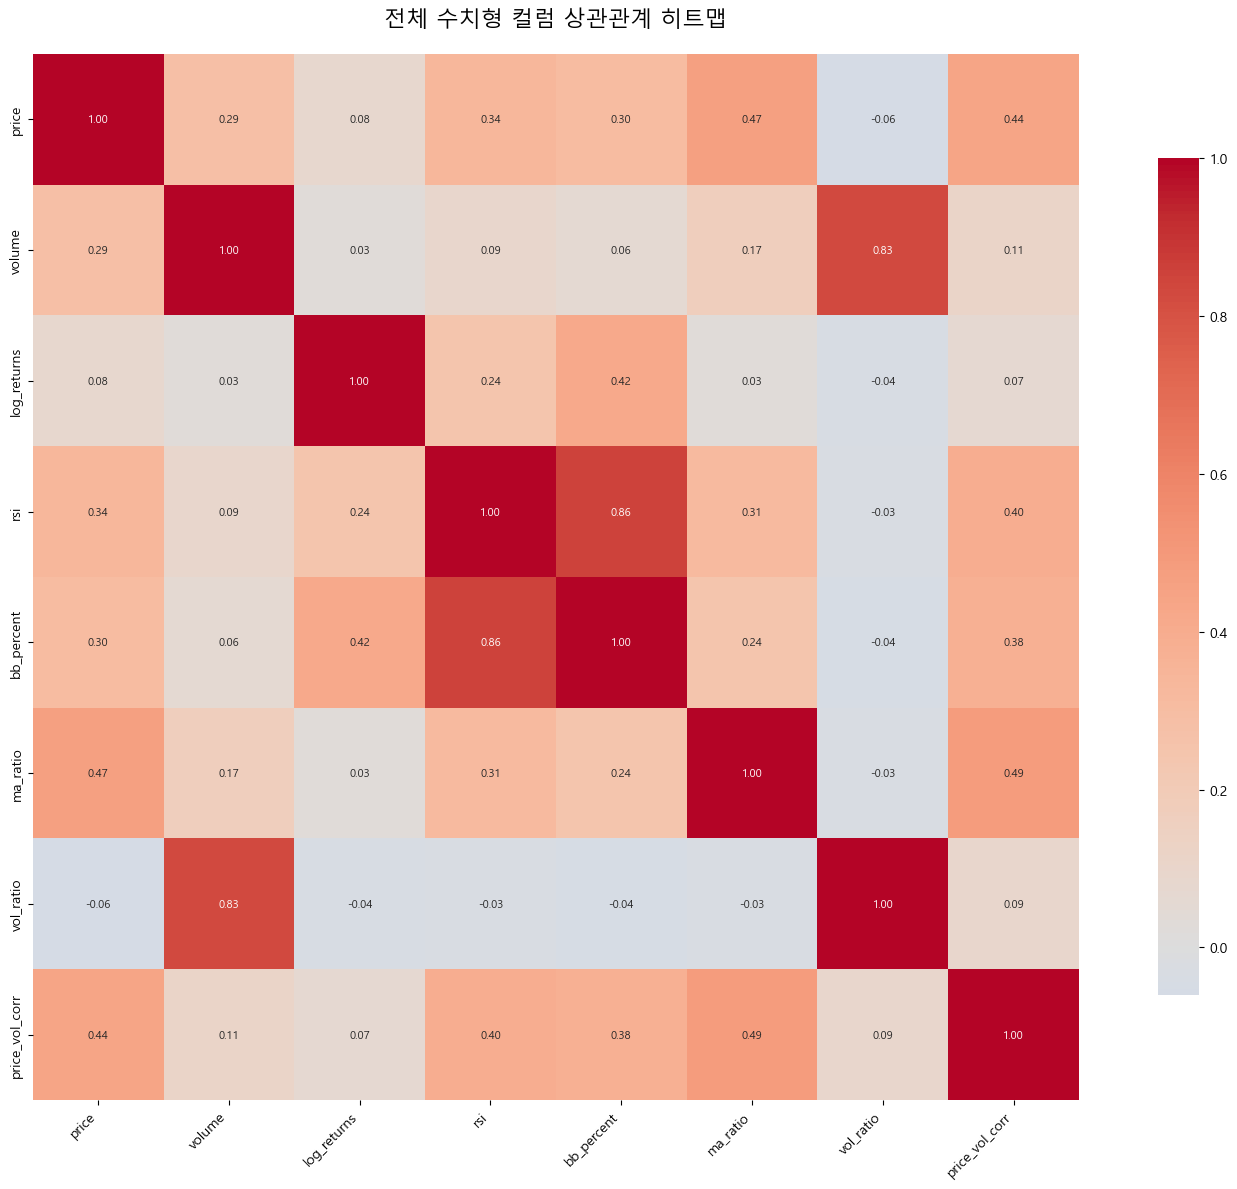

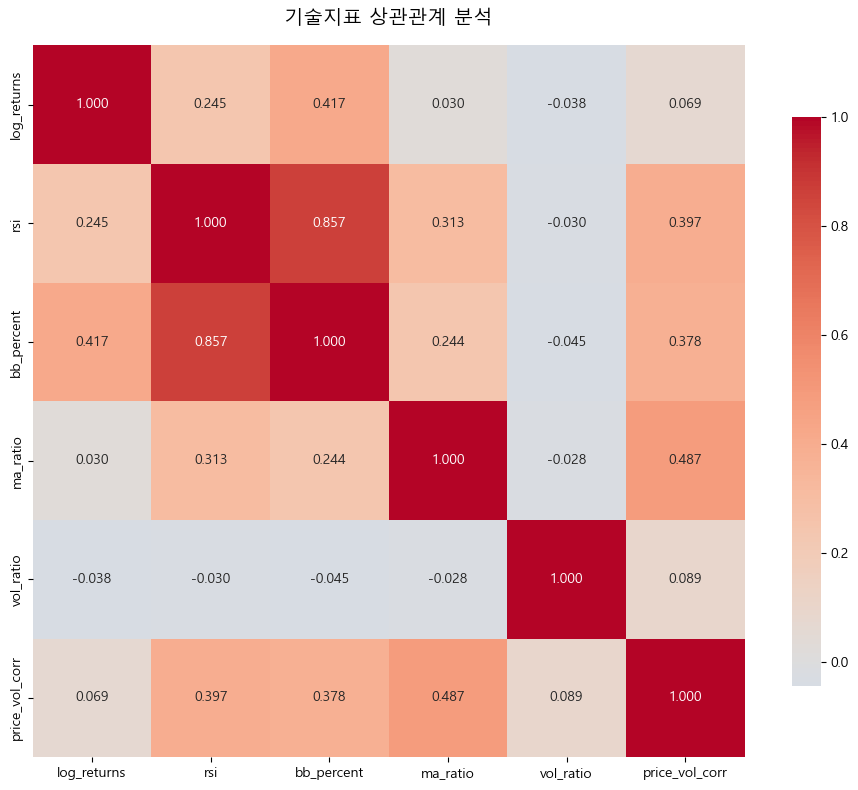

강한 상관관계 (|상관계수| >= 0.7):
 1. 양의 rsi <-> bb_percent: 0.857
 2. 양의 volume <-> vol_ratio: 0.833

모델 성능:
MSE: 0.000537
MAE: 0.017009
R²: -0.6614
RMSE: 0.023179

특성 중요도:
price_vol_corr: 0.245
vol_ratio: 0.213
bb_percent: 0.197
ma_ratio: 0.177
rsi: 0.168


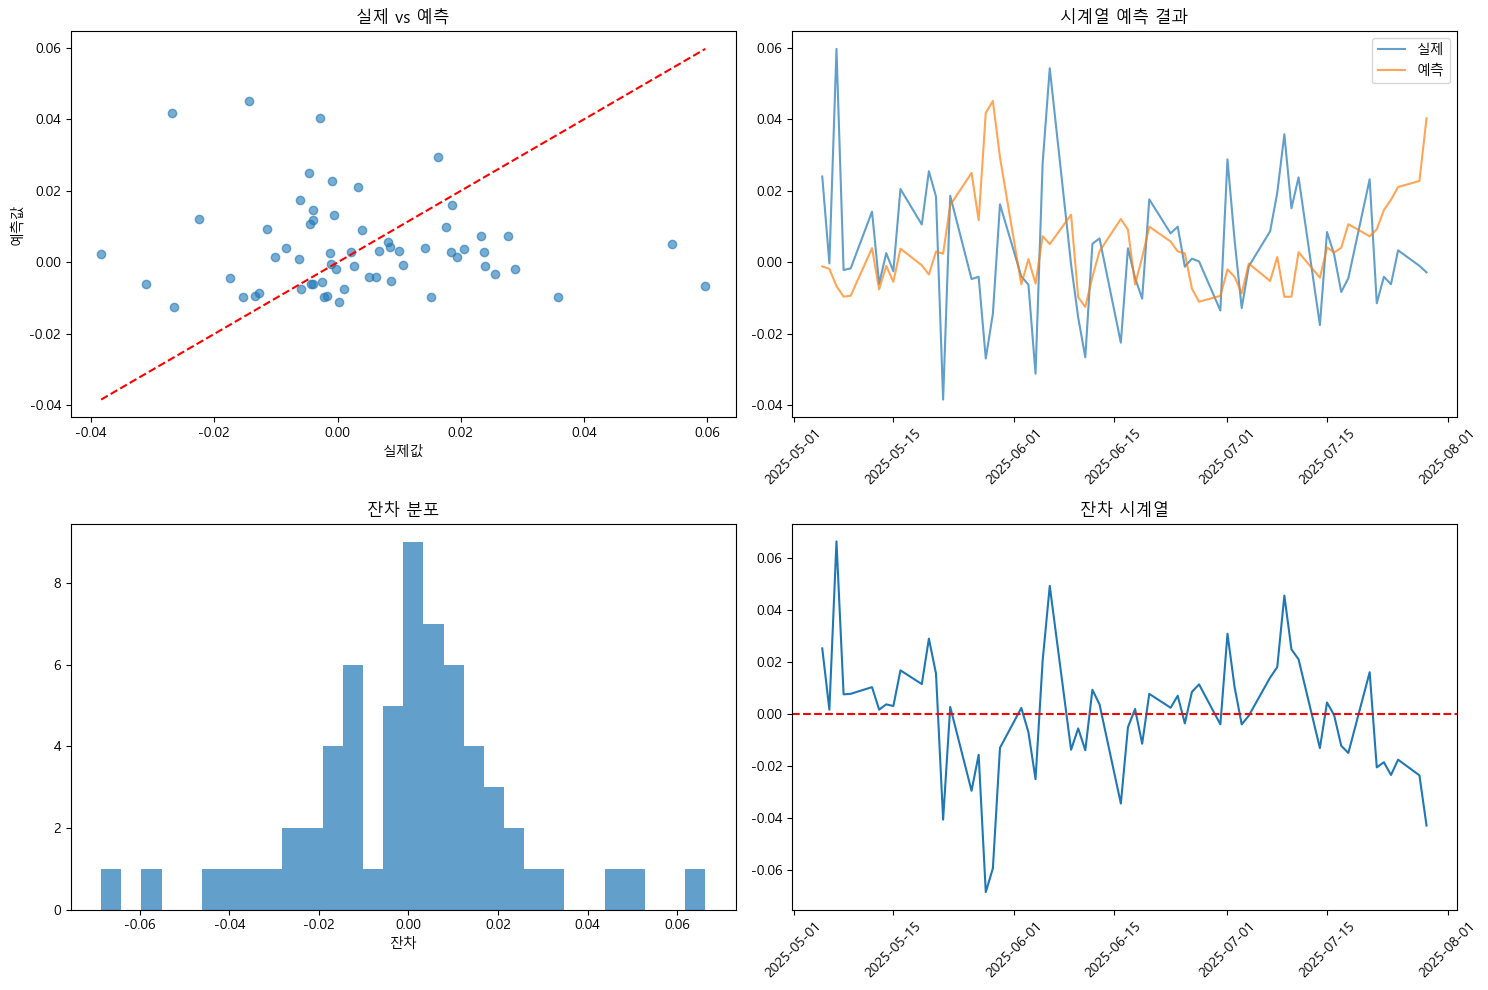


분석 완료
데이터 크기: 311행
분석 기간: 2024-05-21 ~ 2025-07-30
생성된 기술지표: 6개


In [123]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('merged_data_features.csv')

if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df.iloc[:, 0])
else:
    df['date'] = pd.to_datetime(df['date'])

if 'btc_usd' not in df.columns and 'BTC_EUR' in df.columns and 'USD_EUR' in df.columns:
    df['btc_usd'] = df['BTC_EUR'] / df['USD_EUR']

price_col = 'btc_usd' if 'btc_usd' in df.columns else 'price'
volume_cols = [col for col in df.columns if 'volume' in col.lower()]
volume_col = volume_cols[0] if volume_cols else None

technical_indicators = ['log_returns', 'rsi', 'bb_percent', 'ma_ratio', 'vol_ratio', 'price_vol_corr']

if 'log_returns' not in df.columns:
    df['log_returns'] = np.log(df[price_col] / df[price_col].shift(1))

if 'rsi' not in df.columns:
    delta = df[price_col].diff()
    gain = delta.where(delta > 0, 0).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    rs = gain / loss
    df['rsi'] = 100 - (100 / (1 + rs))

if 'bb_percent' not in df.columns:
    ma = df[price_col].rolling(20).mean()
    std = df[price_col].rolling(20).std()
    upper = ma + (2 * std)
    lower = ma - (2 * std)
    df['bb_percent'] = (df[price_col] - lower) / (upper - lower)

if 'ma_ratio' not in df.columns:
    ma_20 = df[price_col].rolling(20).mean()
    ma_50 = df[price_col].rolling(50).mean()
    df['ma_ratio'] = ma_20 / ma_50

if 'vol_ratio' not in df.columns and volume_col:
    vol_ma = df[volume_col].rolling(20).mean()
    df['vol_ratio'] = df[volume_col] / vol_ma

if 'price_vol_corr' not in df.columns and volume_col:
    df['price_vol_corr'] = df[price_col].rolling(20).corr(df[volume_col])

df.to_csv('merged_data_features.csv', index=False)

df = df.dropna(subset=['log_returns'])

fill_values = {
    'rsi': 50,
    'bb_percent': 0.5,
    'ma_ratio': 1.0,
    'vol_ratio': 1.0,
    'price_vol_corr': 0.0
}

for col, fill_val in fill_values.items():
    if col in df.columns:
        df[col] = df[col].fillna(fill_val)

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
exclude_cols = ['Unnamed: 0', 'index']
numeric_cols = [col for col in numeric_cols if col not in exclude_cols]

corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(16, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, 
            annot=True, 
            cmap='coolwarm', 
            center=0,
            square=True,
            fmt='.2f',
            cbar_kws={"shrink": .8},
            annot_kws={'size': 8})

plt.title('전체 수치형 컬럼 상관관계 히트맵', fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('correlation_heatmap_full.png', dpi=300, bbox_inches='tight')
plt.show()

available_indicators = [col for col in technical_indicators if col in df.columns]
if len(available_indicators) >= 2:
    tech_corr = df[available_indicators].corr()
    
    plt.figure(figsize=(10, 8))
    mask = np.triu(np.ones_like(tech_corr, dtype=bool))
    sns.heatmap(tech_corr,
                annot=True,
                cmap='coolwarm',
                center=0,
                square=True,
                fmt='.3f',
                cbar_kws={"shrink": .8})
    
    plt.title('기술지표 상관관계 분석', fontsize=14, pad=15)
    plt.tight_layout()
    plt.savefig('technical_indicators_correlation.png', dpi=300, bbox_inches='tight')
    plt.show()

strong_pairs = []
n = len(corr_matrix.columns)

for i in range(n):
    for j in range(i+1, n):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) >= 0.7:
            strong_pairs.append({
                'var1': corr_matrix.columns[i],
                'var2': corr_matrix.columns[j],
                'correlation': corr_val
            })

strong_pairs.sort(key=lambda x: abs(x['correlation']), reverse=True)

print("강한 상관관계 (|상관계수| >= 0.7):")
for i, pair in enumerate(strong_pairs[:15], 1):
    direction = "양의" if pair['correlation'] > 0 else "음의"
    print(f"{i:2d}. {direction} {pair['var1']} <-> {pair['var2']}: {pair['correlation']:.3f}")

feature_cols = [col for col in technical_indicators if col in df.columns and col != 'log_returns']
df['target'] = df['log_returns'].shift(-1)

clean_data = df.dropna()
X = clean_data[feature_cols]
y = clean_data['target']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

split_idx = int(len(X_scaled) * 0.8)
X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\n모델 성능:")
print(f"MSE: {mse:.6f}")
print(f"MAE: {mae:.6f}")
print(f"R²: {r2:.4f}")
print(f"RMSE: {np.sqrt(mse):.6f}")

importance = model.feature_importances_
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': importance
}).sort_values('importance', ascending=False)

print(f"\n특성 중요도:")
for _, row in feature_importance.iterrows():
    print(f"{row['feature']}: {row['importance']:.3f}")

dates = clean_data.iloc[split_idx:]['date']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0,0].scatter(y_test, y_pred, alpha=0.6)
axes[0,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[0,0].set_xlabel('실제값')
axes[0,0].set_ylabel('예측값')
axes[0,0].set_title('실제 vs 예측')

axes[0,1].plot(dates, y_test.values, label='실제', alpha=0.7)
axes[0,1].plot(dates, y_pred, label='예측', alpha=0.7)
axes[0,1].set_title('시계열 예측 결과')
axes[0,1].legend()
axes[0,1].tick_params(axis='x', rotation=45)

residuals = y_test.values - y_pred
axes[1,0].hist(residuals, bins=30, alpha=0.7)
axes[1,0].set_title('잔차 분포')
axes[1,0].set_xlabel('잔차')

axes[1,1].plot(dates, residuals)
axes[1,1].axhline(y=0, color='r', linestyle='--')
axes[1,1].set_title('잔차 시계열')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('prediction_results.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n분석 완료")
print(f"데이터 크기: {len(df):,}행")
print(f"분석 기간: {df['date'].min().strftime('%Y-%m-%d')} ~ {df['date'].max().strftime('%Y-%m-%d')}")
print(f"생성된 기술지표: {len(available_indicators)}개")

if 'btc_usd' in df.columns:
    price_stats = df['btc_usd'].describe()
    print(f"BTC/USD 평균: ${price_stats['mean']:,.2f}")
    print(f"BTC/USD 최고: ${price_stats['max']:,.2f}")
    print(f"BTC/USD 최저: ${price_stats['min']:,.2f}")